In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1591 files belonging to 15 classes.
Using 1273 files for training.
Found 1591 files belonging to 15 classes.
Using 318 files for validation.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 283s 6s/step - accuracy: 0.1500 - loss: 53.4691 - val_accuracy: 0.4151 - val_loss: 23.3748
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 469ms/step - accuracy: 0.4163 - loss: 23.2967 - val_accuracy: 0.5881 - val_loss: 14.1976
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - accuracy: 0.5554 - loss: 15.0160 - val_accuracy: 0.5692 - val_loss: 12.3349
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.6718 - loss: 9.5469 - val_accuracy: 0.7170 - val_loss: 8.4004
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - accuracy: 0.7051 - loss: 7.9502 - val_accuracy: 0.8270 - val_loss: 5.4673
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 481ms/step - accuracy: 0.7676 - loss: 5.5936 - val_accuracy: 0.7421 - val_loss: 7.6706
Epoch 7/30
40/40 ━━━━━━━

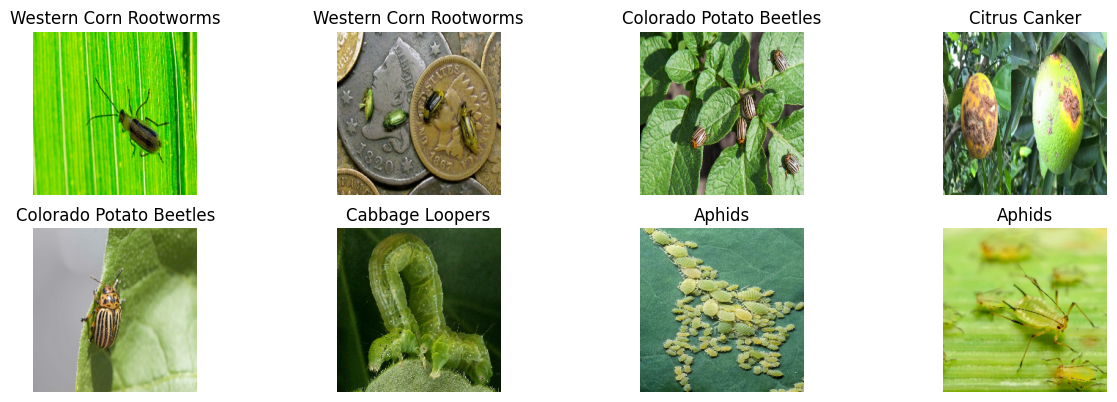

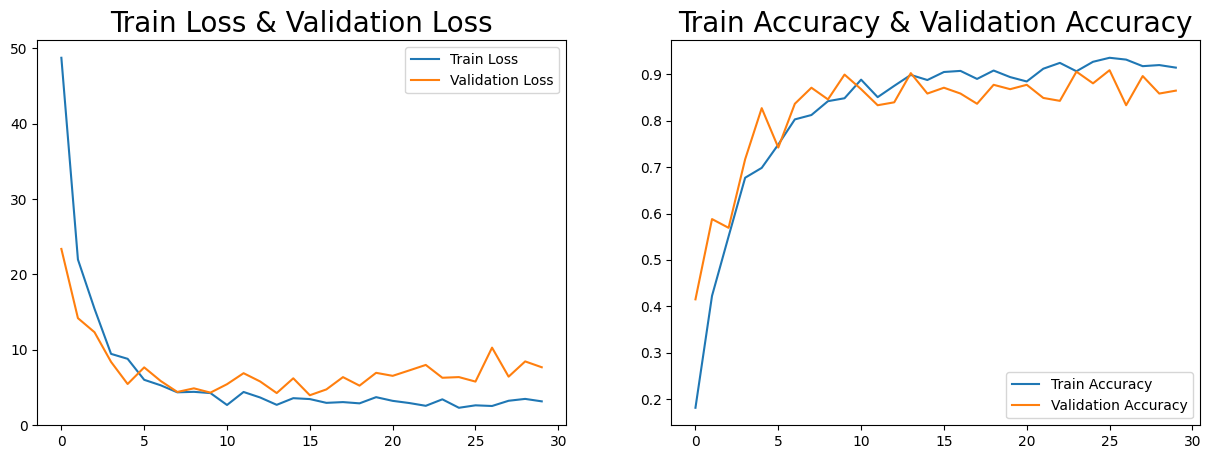

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 999ms/step


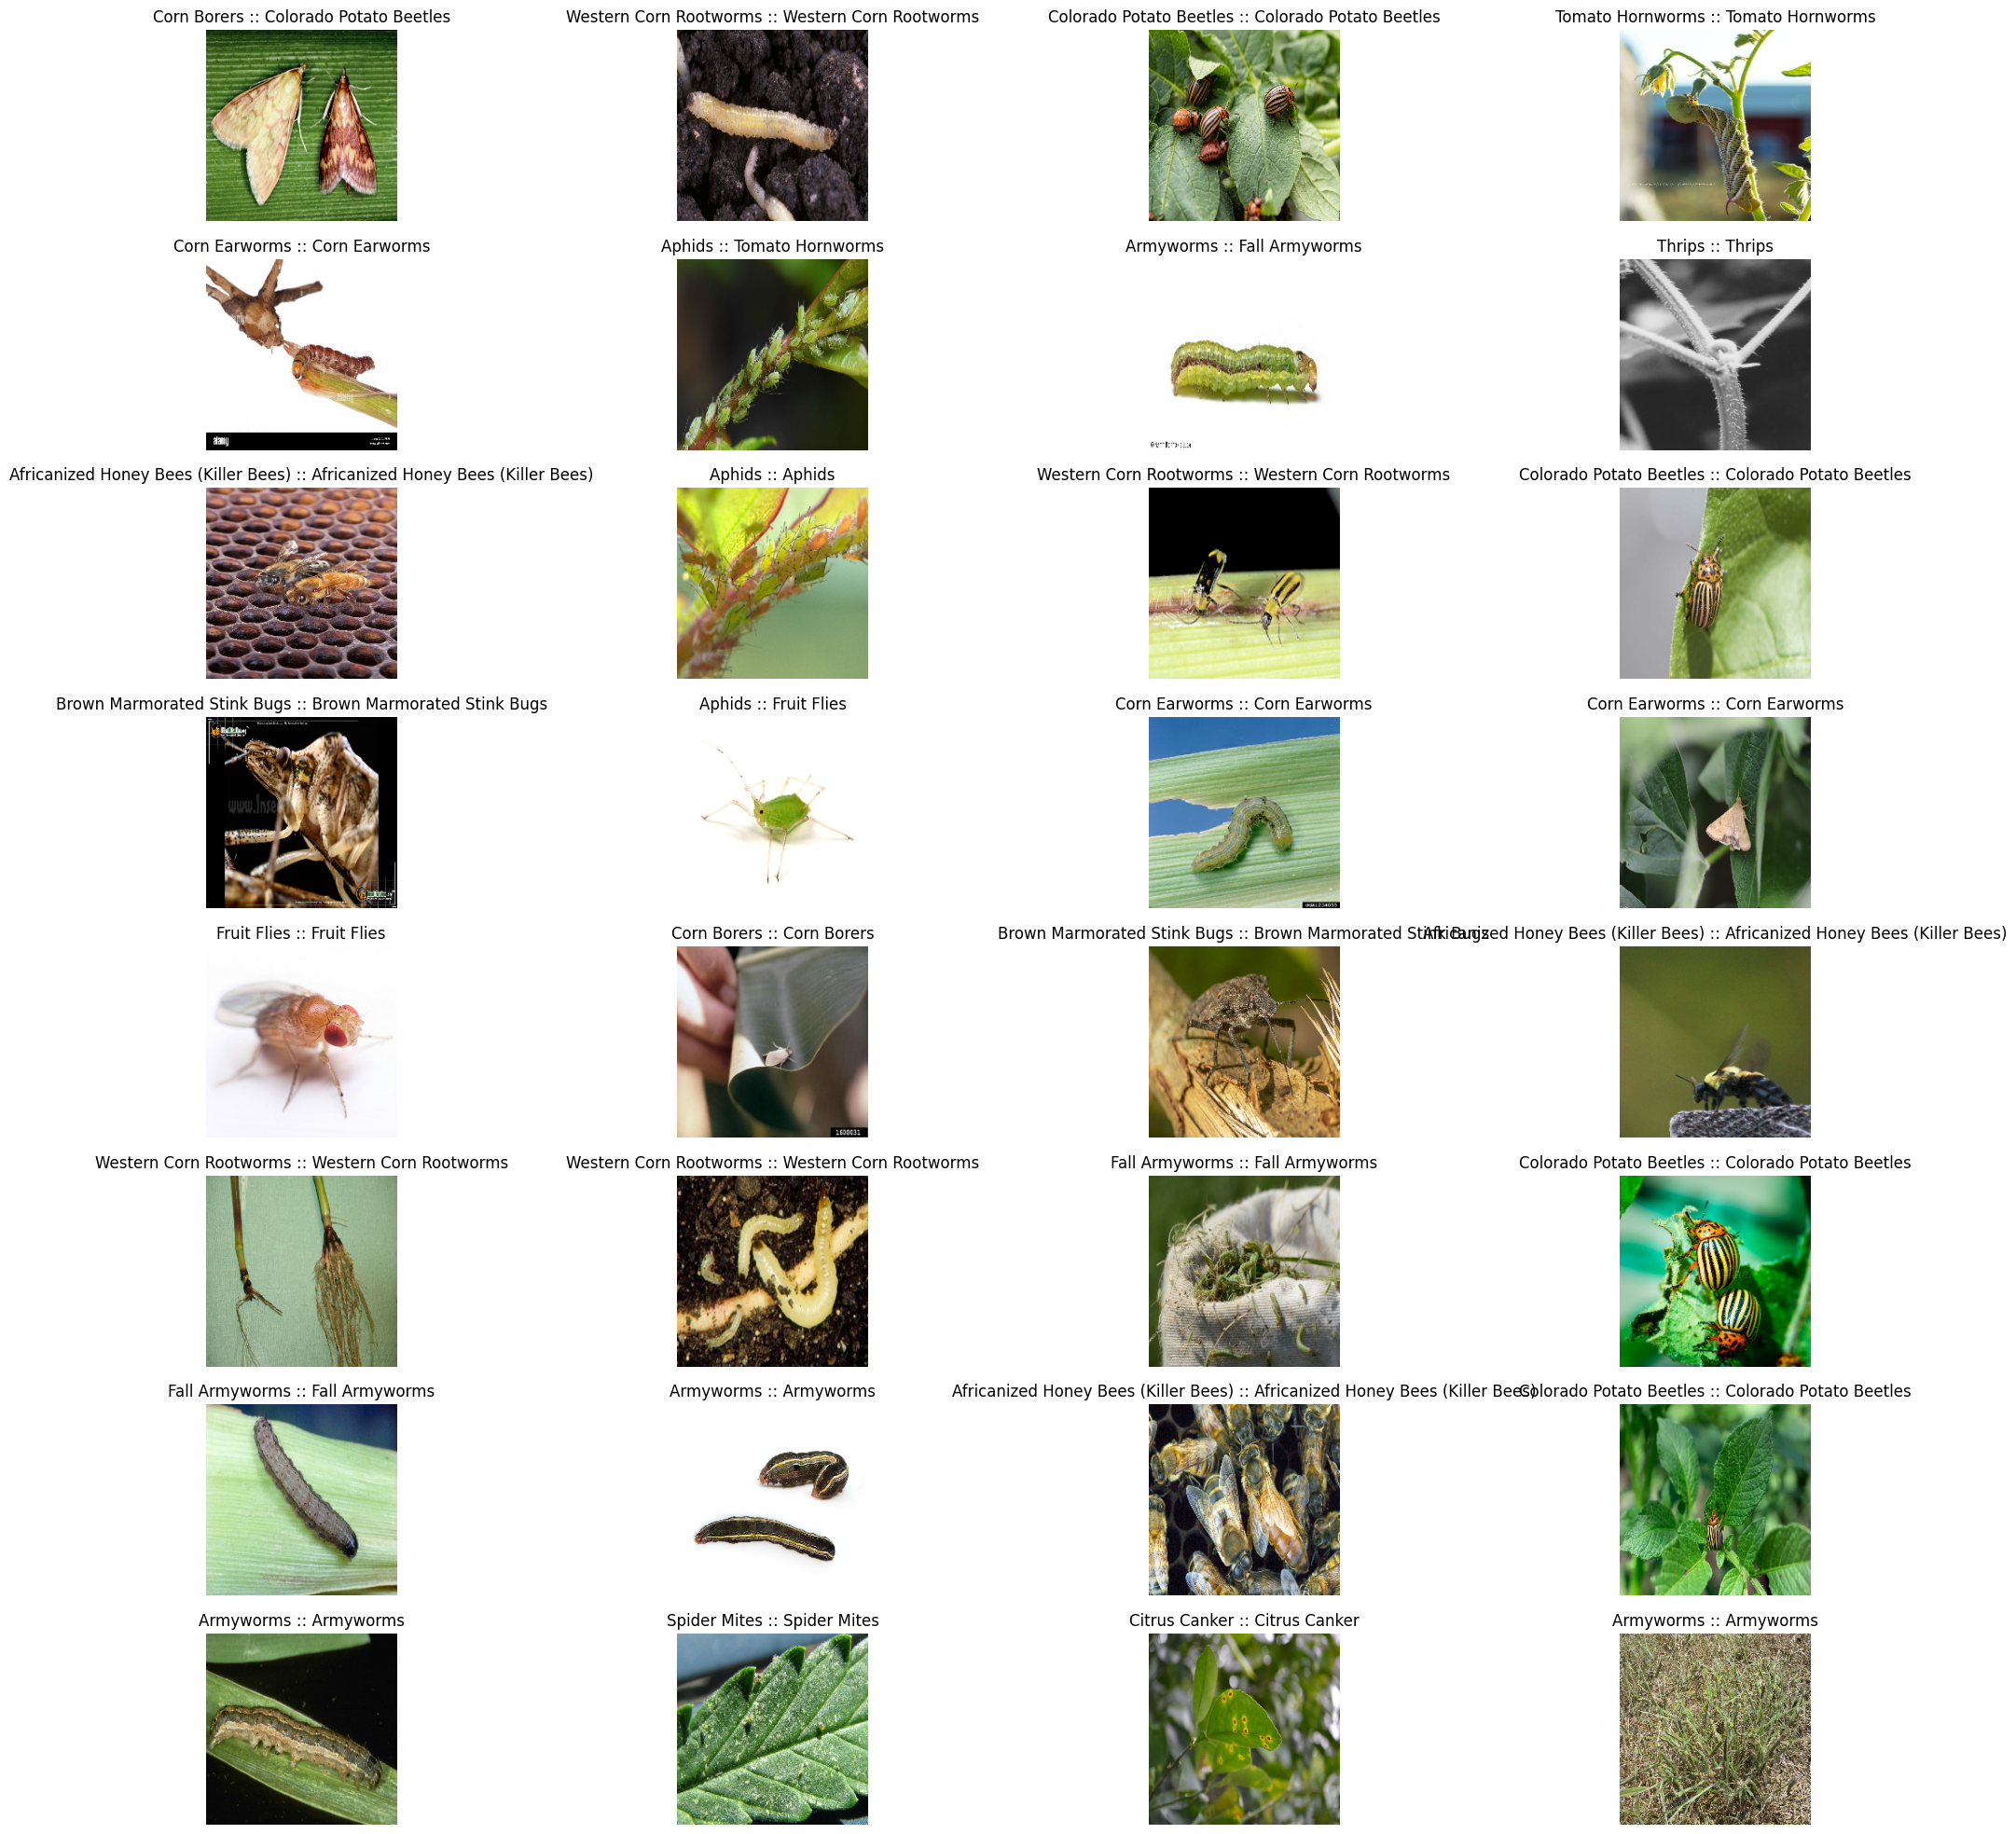

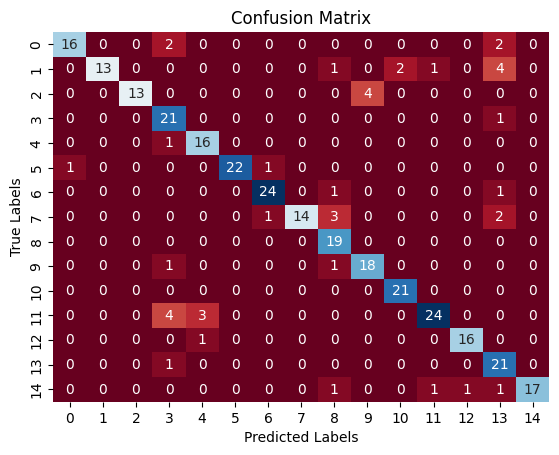

Accuracy is: 86.478%


In [8]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

image_data = '/content/drive/MyDrive/farm_insects (1)'
pd.DataFrame(os.listdir(image_data), columns=['Files_Name'])

train_data_dir = image_data
batch_size = 32
target_size = (224, 224)
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names

plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

keras_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation=tf.nn.softmax)
])

tf.keras.utils.plot_model(keras_model,
                          to_file='model_densenet121.png',
                          show_shapes=True,
                          show_layer_names=True,
                          show_dtype=True,
                          dpi=80)

keras_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

hist = keras_model.fit(train, epochs=30, validation_data=validation)

hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.show()

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

df = pd.DataFrame()
df['Actual'], df['Prediction'] = y_val, y_pred

plt.figure(figsize=(25, 25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")
plt.show()

ax = plt.subplot()
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

acc = accuracy_score(y_val, y_pred)
print("Accuracy is: {0:.3f}%".format(acc * 100))
